In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## import CSV to dataframe
df = pd.read_csv("Spotify Dataset Cleaned Model.csv")
df.drop("Unnamed: 0",axis=1,inplace=True)
df.head()

## One Hot Encoding for categorical data 
df = pd.get_dummies(data=df,columns=["mode","key",'time_signature'],drop_first=True)

## Setting Features and Target
y = df["popularity"]
X = df.drop(["popularity","track_name","artist_name"],axis=1)

### Import All Regression model for prediction

In [3]:
## Trying all regression model with KFold to evaluate the MAE and RMSE

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

def regression_model(n_cv):
    score = []
    model_name = ['Linear Regression','Lasso','Ridge','DecisionTreeRegressor','RandomForestRegressor','GradientBoostingRegressor',"XGBRegressor","KNeighborsRegressor"]
    models = [LinearRegression,Lasso,Ridge,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,KNeighborsRegressor]
    for item in models:
        rmse = []
        mae = []
        r2 = []
        kf = KFold(n_splits=n_cv,shuffle=True)
        for train_index , test_index in kf.split(X,y):
            X_train,X_test,y_train,y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
            model = item()
            model.fit(X_train,y_train)
            prediction = model.predict(X_test)
            mae.append(round(mean_absolute_error(y_test,prediction),2))
            rmse.append(round(np.sqrt(mean_squared_error(y_test,prediction)),2))
            r2.append(round(r2_score(y_test,prediction),2))

        temp = [
            sum(mae)/n_cv,
            sum(rmse)/n_cv,
            sum(r2)/n_cv
        ]
        score.append(temp)
    return pd.DataFrame(score,columns=['MAE','RMSE',"R2 Score"],index=model_name)

C:\Users\Windows\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
regression_model(5)

,MAE,RMSE,R2 Score
Linear Regression,7.074,8.736,0.084
Lasso,7.280,8.996,0.028
Ridge,7.072,8.734,0.084
DecisionTreeRegressor,9.402,11.890,-0.698
RandomForestRegressor,6.746,8.432,0.146
GradientBoostingRegressor,6.800,8.438,0.144
XGBRegressor,6.944,8.646,0.102
KNeighborsRegressor,7.870,9.782,-0.148


From those error rate, will choose RandomForestRegressor for the primary model as it has the lowest error rate for both MAE and RMSE and best accuracy

## Modelling with RandomForestRegressor

Text(0.5, 1.0, 'CV Score for test size')

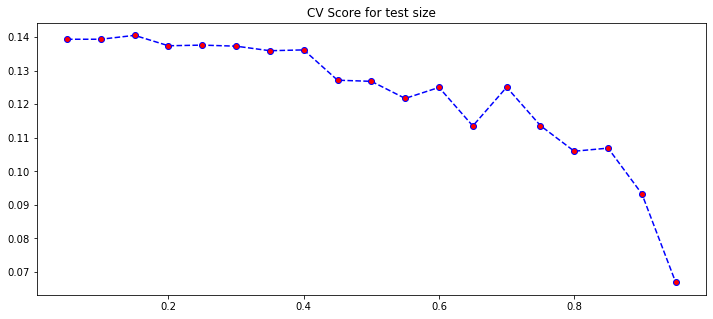

In [5]:
#### Finding best test size with learning curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

cv_scores = []
training_size = np.arange(0.05,1,0.05)
for item in training_size:
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=101,test_size=item)
    cv_mean = cross_val_score(RandomForestRegressor(random_state=101),X_train,y_train,cv=5).mean()
    cv_scores.append(cv_mean)
    
dfCV = pd.DataFrame(cv_scores,columns=["score"],index=np.arange(0.05,1,0.05))

plt.figure(figsize=(12,5))
plt.plot(dfCV,color="blue",marker="o",markerfacecolor="red",linestyle="--")
plt.title("CV Score for test size")

Test size with the best CV Score is 15% of total data, although the differences between 10-20% is not really significant

In [40]:
### Train Test Split the data with the best test size number and fitting the model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=101)
print("Train data has {} rows and Test data has {} rows".format(X_train.shape[0],X_test.shape[0]))

model = RandomForestRegressor(random_state=101)
model.fit(X_train,y_train)

Train data has 16433 rows and Test data has 2900 rows


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

### Predicting Data Train

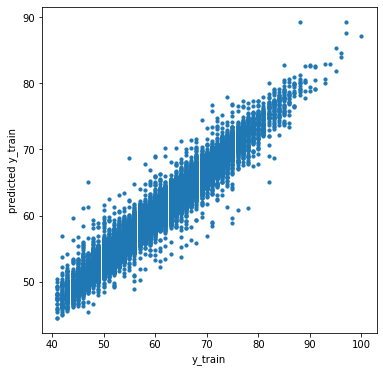

In [41]:
plt.figure(figsize=(6,6))
predictions_train = model.predict(X_train)
plt.scatter(y_train,predictions_train, s=10)
plt.xlabel("y_train")
plt.ylabel("predicted y_train")
plt.show()

Text(0.5, 1.0, 'Residual Distribution')

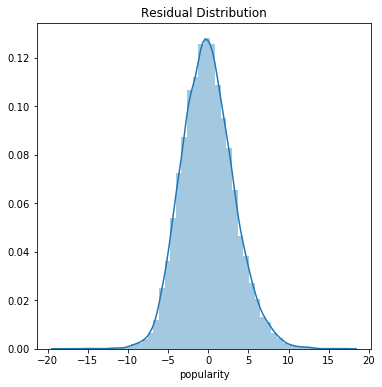

In [42]:
## Residual
plt.figure(figsize=(6,6))
sns.distplot(y_train-predictions_train,bins=50)
plt.title("Residual Distribution")

In [43]:
print('MAE:', mean_absolute_error(y_train, predictions_train))
print('RMSE:', np.sqrt(mean_squared_error(y_train, predictions_train)))
print('R2_Score:', r2_score(y_train,predictions_train))

MAE: 2.558293140544723
RMSE: 3.2539801046384893
R2_Score: 0.8727832557373014


The error rate for the training data is really good. Check with test data for overfitting or underfitting

### Predicting Data Test

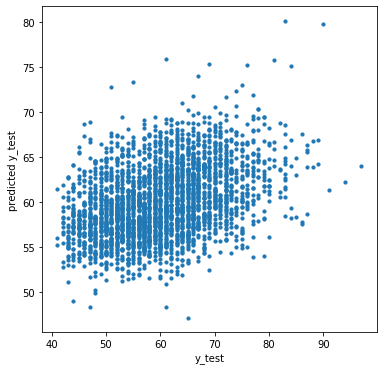

In [44]:
plt.figure(figsize=(6,6))
predictions_test = model.predict(X_test)
plt.scatter(y_test,predictions_test, s=10)
plt.xlabel("y_test")
plt.ylabel("predicted y_test")
plt.show()

The scatter look pretty okay for popularity better 50-70. But for the higher popularity is not really good

Text(0.5, 1.0, 'Residual Distribution')

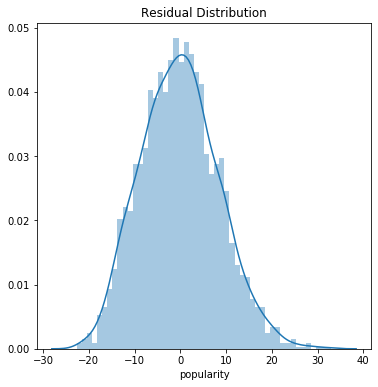

In [45]:
## Residual
plt.figure(figsize=(6,6))
sns.distplot(y_test-predictions_test,bins=50)
plt.title("Residual Distribution")

The residual for the test data is already in normal distribution.

((array([-3.492805  , -3.24848854, -3.11334967, ...,  3.11334967,
          3.24848854,  3.492805  ]),
  array([-22.63607143, -21.93      , -21.83      , ...,  29.68      ,
          31.75083333,  32.99      ])),
 (8.434874190038467, -0.12757898741105808, 0.9978731394066623))

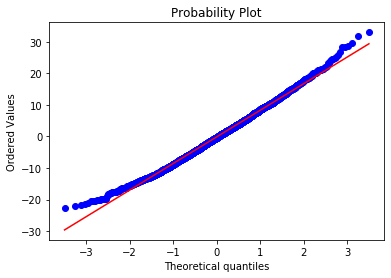

In [56]:
import scipy.stats as stats
import pylab
stats.probplot(y_test-predictions_test,dist="norm", plot=pylab)

From the qqplot statistical normality test, the residual looks already normally distributed, even there are still a bit of differences

In [46]:
# Normality Test
from scipy.stats import anderson, normaltest
def try_normal(data):
    result = {"Anderson" : {i: j for i,j in zip(anderson(data)[2],anderson(data)[1])}}
    result["Anderson"]['stats'] = anderson(data)[0]
    return result

try_normal(y_test-predictions_test)

{'Anderson': {15.0: 0.575,
  10.0: 0.655,
  5.0: 0.786,
  2.5: 0.917,
  1.0: 1.09,
  'stats': 1.7079871524347254}}

In [29]:
print('MAE:', mean_absolute_error(y_test, predictions_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions_test)))
print('R2_Score:', r2_score(y_test,predictions_test))

MAE: 6.777084740010946
RMSE: 8.444644518171511
R2_Score: 0.1496404776274164


The error is pretty good for with less than 9% of rate. While the R2 score is not good, the variance from the data is quite big. I guess if i can collect more real data from the API for songs with popularity in 70-100 it will make the model a lot better. The problem is the API is not currently capable for user to filter song with popularity feature and limit the user to take only 2000 songs per year.

Text(0.5, 1.0, 'Feature Importance from RandomForestRegressor Modelling with Best Params')

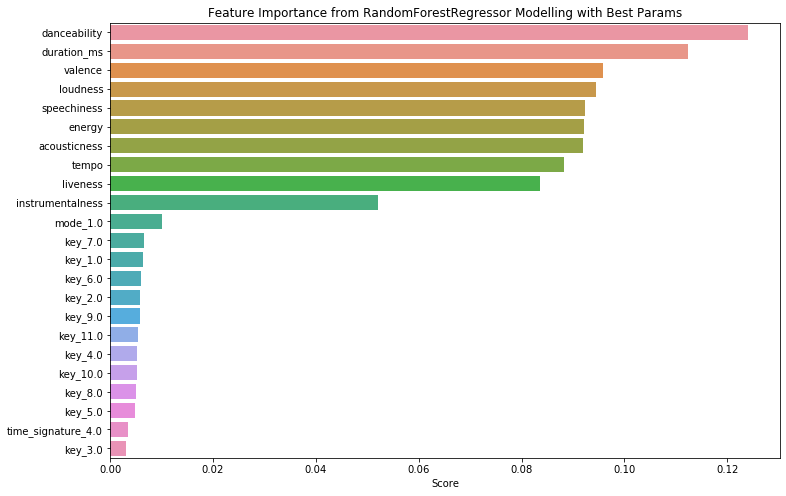

In [16]:
score = pd.DataFrame(model.feature_importances_,columns=["Score"],index=X.columns)
score = score.sort_values(by="Score",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(data=score,x="Score",y=score.index)
plt.title("Feature Importance from RandomForestRegressor Modelling with Best Params")

## Trying RandomizedSearchCV for BestParameters

In [18]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor(random_state=101)

search = RandomizedSearchCV(estimator=rfr,
                     param_distributions={
                         "n_estimators" : [100,300,500,700,1000],
                         "min_samples_leaf" : np.arange(1,11),
                         "min_samples_split" : np.arange(2,11),
                         "bootstrap" : [True,False]
                     },cv=5,scoring="neg_mean_squared_error",random_state=101)

search.fit(X_train,y_train)

search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'bootstrap': True}

## Modelling with Best params

In [57]:
model = RandomForestRegressor(n_estimators=1000,min_samples_leaf=2,min_samples_split=8,random_state=101)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

#### Predicting Test Data

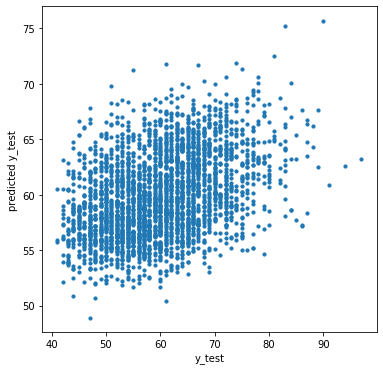

In [58]:
plt.figure(figsize=(6,6))
predictions_test = model.predict(X_test)
plt.scatter(y_test,predictions_test, s=10)
plt.xlabel("y_test")
plt.ylabel("predicted y_test")
plt.show()

Text(0.5, 1.0, 'Residual Distribution')

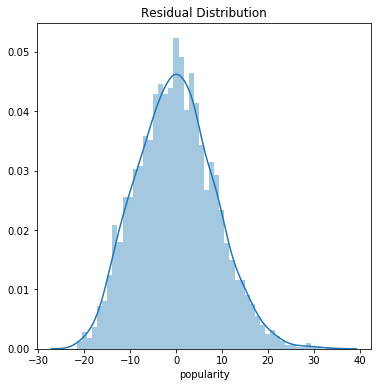

In [59]:
## Residual
plt.figure(figsize=(6,6))
sns.distplot(y_test-predictions_test,bins=50)
plt.title("Residual Distribution")

((array([-3.492805  , -3.24848854, -3.11334967, ...,  3.11334967,
          3.24848854,  3.492805  ]),
  array([-21.62847784, -21.14427106, -20.85087691, ...,  30.09895061,
          31.41810771,  33.77275745])),
 (8.409722820398427, -0.06351164506628837, 0.9977040515765736))

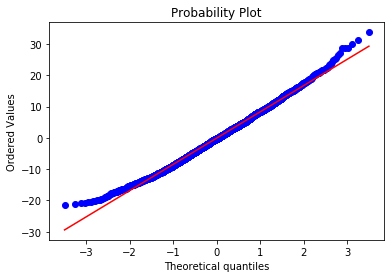

In [60]:
stats.probplot(y_test-predictions_test,dist="norm", plot=pylab)

The residual already looks normal from the qqplot normality test.

Default Parameter Result


MAE: 6.777084740010946

RMSE: 8.444644518171511

R2_Score: 0.1496404776274164


In [21]:
print('MAE:', mean_absolute_error(y_test, predictions_test))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions_test)))
print("R2 Score:", r2_score(y_test, predictions_test))

MAE: 6.745206152466815
RMSE: 8.420169395939741
R2 Score: 0.15456253030558875


The prediction get bettter just a little bit. But for now after trying other model, oversampling, this result is still the best out of the other. So decided to pick this model and parameter for the best model.

In [12]:
model_prediction = RandomForestRegressor(n_estimators=1000,min_samples_leaf=2,min_samples_split=8,random_state=101)
model_prediction.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

In [23]:
import pickle
pickle.dump(model_prediction,open("regression.sav","wb"))

# Predicting Popularity with Existing Song from Spotify Library

In [13]:
### Import Spotipy API and authenticating
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '9d6662eb9b5d4385a41336390cd9053e'
secret = 'd36d9e2db9fb4da8b4e15cf72a9835ae'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)

### Creating function to read the tracks from the API, get the audio analysis and predict the popularity score
def prediction_song(data):
    id = sp.search(q="artist:{} track:{}".format(data["artist_name"],data["track_name"]),type="track",limit=1)['tracks']["items"][0]["id"]
    audio_features = sp.audio_features(id)[0]
    data1 = pd.DataFrame(audio_features,index=[0])
    data1 = data1.drop(["type","id","uri","track_href","analysis_url"],axis=1)
    data1[["key","mode","time_signature"]] = data1[["key","mode","time_signature"]].astype('object')
    data1 = pd.get_dummies(data=data1,columns=["mode","key",'time_signature'])
    data1 = data1.reindex(columns=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'mode_1.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0',
       'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0',
       'time_signature_4.0'], fill_value=0)
    result = model_prediction.predict(data1)
    result = int(round(result[0]))
    cover = sp.track(id)['album']['images'][1]['url']
    spotify = "https://open.spotify.com/track/" + str(id)
    name = data["artist_name"]
    track = data["track_name"]
    return result, cover, spotify, name, track

In [14]:
## Printing the result
result = prediction_song({'track_name': 'Bali', 'artist_name': 'Rich Brian'})
print("Predicted popularity Score is {}".format(result[0]))
print("Cover Art link: {}".format(result[1]))
print("Spotify link: {}".format(result[2]))
print("Artist Name: {}".format(result[3]))
print("Track Name: {}".format(result[4]))

Predicted popularity Score is 64
Cover Art link: https://i.scdn.co/image/ab67616d00001e0289c120e41ac7ccdea35ddcd9
Spotify link: https://open.spotify.com/track/2XW3vH6ZqMHvlzUSfhWW2X
Artist Name: Rich Brian
Track Name: Bali


In [ ]:
### Other test

## Oversampling Data with SMOTE

In [32]:
## Checking the Distribution per 10th of data
p0 = 0
p10 = 0
p20 = 0
p30 = 0
p40 = 0
p50 = 0
p60 = 0
p70 = 0
p80 = 0
p90 = 0

for item in df["popularity"]:
    if item >= 0 and item <=10:
        p0 += 1
    elif item >10 and item <=20:
        p10 += 1
    elif item >20 and item <=30:
        p20 += 1
    elif item >30 and item <=40:
        p30 += 1
    elif item >40 and item <=50:
        p40 += 1
    elif item >50 and item <=60:
        p50 += 1
    elif item >60 and item <=70:
        p60 += 1
    elif item >70 and item <=80:
        p70 += 1
    elif item >80 and item <=90:
        p80 += 1
    elif item >90 and item <= 100:
        p90 +=1
        
## Creating the Dataframe for Data count 
pd.DataFrame({
    "Count" : [p0,p10,p20,p30,p40,p50,p60,p70,p80,p90]
},index=["0-10","11-20",'21-30','31-40','41-50','51-60','61-70','71-80','81-90','91-100'])

,Count
0-10,0
11-20,0
21-30,0
31-40,0
41-50,3318
51-60,7099
61-70,6447
71-80,2136
81-90,314
91-100,19


> Since the data under 40 is 0, so we couldn't oversampling it. Will focus on 70-100.

In [36]:
df_smote = df.copy()

criteria = [df_smote['popularity'].between(0,50),df_smote['popularity'].between(51,60),
            df_smote['popularity'].between(61,70),df_smote["popularity"].between(71,100)]
values = [0,1,2,3]

df_smote["smote"] = np.select(criteria,values,0)
X_smote = df_smote.drop(['track_name',"artist_name"],axis=1)
y_smote = df_smote["smote"]

from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_sm, y_sm = sm.fit_sample(X_smote,y_smote)

## Checking the Smote data amount
np.bincount(y_sm)

array([7099, 7099, 7099, 7099], dtype=int64)

In [39]:
## Fixing the Dataframe
dfSM = X_sm.drop("smote",axis=1)

## Setting Target and Feature
Xsm = dfSM.drop(["popularity"],axis=1)
ysm = dfSM["popularity"]

## Putting to model
ln = LinearRegression()
ln.fit(Xsm, ysm)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Predicting from Data Train

Text(0, 0.5, 'predicted ysm')

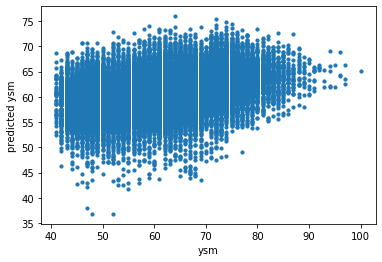

In [40]:
prediction_smote_ln = ln.predict(Xsm)
plt.scatter(ysm,prediction_smote_ln, s=10)
plt.xlabel("ysm")
plt.ylabel("predicted ysm")

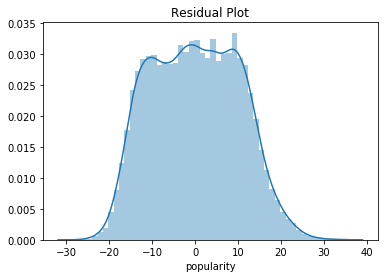

In [41]:
plt.title("Residual Plot")
sns.distplot((ysm - prediction_smote_ln))

In [43]:
print('MAE:', metrics.mean_absolute_error(ysm, prediction_smote_ln))
print('RMSE:', np.sqrt(metrics.mean_squared_error(ysm, prediction_smote_ln)))
print("R2 Score:", r2_score(ysm, prediction_smote_ln))

MAE: 8.598005791956936
RMSE: 10.182106023210421
R2 Score: 0.13749394661551295


## Predicting Data Test

Text(0, 0.5, 'predicted y_test')

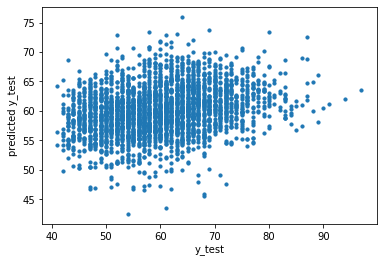

In [44]:
prediction_smote_ln_test = ln.predict(X_test)
plt.scatter(y_test,prediction_smote_ln_test, s=10)
plt.xlabel("y_test")
plt.ylabel("predicted y_test")

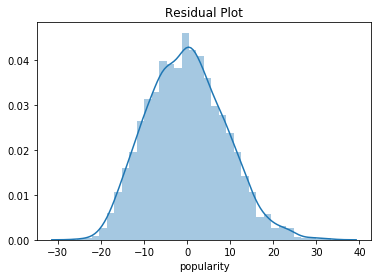

In [45]:
plt.title("Residual Plot")
sns.distplot((y_test - prediction_smote_ln_test))

In [47]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction_smote_ln_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction_smote_ln_test)))
print("R2 Score:", r2_score(y_test, prediction_smote_ln_test))

MAE: 7.20531262159521
RMSE: 8.941286227436674
R2 Score: 0.046677529369054005


The model is underfitting and from the scatter plot it is not representing the correct prediction at all